# Exploratory Data Analysis on COVID-19 in Malta

## Overview

COVID-19 has had a global impact in all aspects of our daily lives, be it in the way we work, communicate and entertain ourselves as well as in our daily habits with regards to health. In Malta, the first official cases of COVID-19 were recorded in March 2020. One of the first actions taken was the suspension of certain travel routes and eventually, a full closure of the national airport. 

This notebook will explore the timeline of COVID-19 in Malta in terms of the daily tests, vaccination and recorded cases. The monthly aggregated data will also be explored in-line with the monthly arrivals at the Malta International Airport (MIA) in Luqa. Thus, this notebook will attempt to address the hypothesis that airline travel has a direct impact on the daily amount of registered COVID-19 cases.


## Data Preparation

For this analysis, two distinct data sources will be used. The first dataset contains COVID-19 data based in Malta and is maintained by the COVID-19 Public Health Response Team (Ministry for Health). The dataset is publicly available at https://github.com/COVID19-Malta/COVID19-Data and is split into numerous subsets. We will be considering the following for this analysis:

1. Aggregate Data - Active Cases, Recoveries and Deaths
2. Vaccination Data - Including dose number and boosters
3. COVID Test Data - PCR and Rapid Antigen Tests

The second dataset is maintained by Eurostat (https://ec.europa.eu/eurostat/databrowser/view/avia_par_mt/default/table?lang=en) and contains data about the airline travel between MIA and its partner airports. The dataset contains monthly, quarterly and annual aggregations as well as various measures based on passengers, seats or flights.

Before performing Exploratory Data Analysis (EDA) on each dataset, a level of preprocessing is required. This involves importing, analysis and cleaning of the data as well as the merging of different datasets. To do so, we will be using Python as well as a number of libraries.

In [1]:
# We import the required packages

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### COVID-19 Datasets

The first COVID-19 dataset is the aggregate dataset. To start off, we import the dataset and preview the first and last rows of the dataset as well as the columns' respective data types.

In [2]:
df_covid_agg = pd.read_csv('./data/covid/COVID-19 Malta - Aggregate Data Set.csv')
df_covid_agg.head() # the first few records
df_covid_agg.tail() # the last records

,Date,New Cases,Total Cases,Recovered,Deaths,Active Cases
1021,22/12/2022,19,116196,114725,812,263
1022,23/12/2022,16,116212,114737,813,266
1023,24/12/2022,19,116231,114746,813,276
1024,25/12/2022,16,116247,114763,813,275
1025,26/12/2022,6,116253,114773,813,271


In [3]:
df_covid_agg.dtypes # the datatypes for each column

Date            object
New Cases        int64
Total Cases      int64
Recovered        int64
Deaths           int64
Active Cases     int64
dtype: object

In [4]:
df_covid_agg.isnull().values.any() # checking for null values

False

The aggregate dataset contains a daily summary of the active cases, recoveries and deaths. The dataset starts from the 06/03/2020 and the data of retrieval i.e. 26/12/2022. The number of days between the first and last date is 1026 days. Therefore, the dataset is expected to have 1026 unique dates or rows.

In [5]:
df_covid_agg.shape # checking the dataframe dimensions (row x column)

(1026, 6)

While there are 1026 rows, a check must also be done for duplicate dates. This can be done by using the 'duplicated' method on the 'Date' column.

In [6]:
df_covid_agg['dup_date'] = df_covid_agg.duplicated(subset=['Date'])
agg_data_dupes = df_covid_agg.loc[df_covid_agg['dup_date'] == True]
agg_data_dupes 

,Date,New Cases,Total Cases,Recovered,Deaths,Active Cases,dup_date
1000,01/11/2022,21,115839,114444,809,190,True


The row with index 1000 seems to be a duplicate. We can investigate further by checking a few rows before and after the duplicate entry.

In [7]:
df_covid_agg.iloc[997:1004] # getting row indices from 997 to 1004

,Date,New Cases,Total Cases,Recovered,Deaths,Active Cases,dup_date
997,28/11/2022,6,115775,114399,809,171,False
998,29/11/2022,15,115790,114415,809,170,False
999,30/11/2022,28,115818,114433,809,180,False
1000,01/11/2022,21,115839,114444,809,190,True
1001,02/12/2022,12,115851,114468,809,178,False
1002,03/12/2022,6,115857,114479,809,173,False
1003,04/12/2022,13,115870,114487,809,178,False


It seems as if the date is wrongly set as 01/11/2022 instead if 01/12/2022. This can be amended manually after converting to the datetime format.

The final step is to convert the 'Date' column into the datetime data type. This will be helpful when plotting or grouping data.

In [8]:
df_covid_agg = df_covid_agg.drop('dup_date', axis=1) # drop the extra column
df_covid_agg.columns = ['date','new_cases','total_cases','recovered','deaths','active_cases'] # set the column names
df_covid_agg['date'] = pd.to_datetime(df_covid_agg['date'],format="%d/%m/%Y") # convert to datetime from 'dd/mm/yyyy' format
df_covid_agg.iat[1000,0] = pd.to_datetime('01/12/2022',format="%d/%m/%Y")
df_covid_agg.iloc[997:1004]
# df_covid_agg.head()


,date,new_cases,total_cases,recovered,deaths,active_cases
997,2022-11-28,6,115775,114399,809,171
998,2022-11-29,15,115790,114415,809,170
999,2022-11-30,28,115818,114433,809,180
1000,2022-12-01,21,115839,114444,809,190
1001,2022-12-02,12,115851,114468,809,178
1002,2022-12-03,6,115857,114479,809,173
1003,2022-12-04,13,115870,114487,809,178


The second COVID-19 dataset is the vaccination dataset. After importing the data, we can preview the dataset and the column datatypes.

In [9]:
df_covid_vacc = pd.read_csv('./data/covid/COVID-19 Malta - Vaccination Data.csv')
df_covid_vacc.head()

,Date of Vaccination,Total Vaccination Doses,Primary Vaccination,Received one dose,Total Booster doses,Total 2nd Booster doses,Omicron booster doses,Total Omicron booster doses
0,17/01/2021,11705,NaN,NaN,NaN,NaN,NaN,NaN
1,18/01/2021,13002,NaN,NaN,NaN,NaN,NaN,NaN
2,19/01/2021,14276,NaN,NaN,NaN,NaN,NaN,NaN
3,20/01/2021,15316,NaN,NaN,NaN,NaN,NaN,NaN
4,21/01/2021,16531,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_covid_vacc.dtypes

Date of Vaccination             object
Total Vaccination Doses         object
Primary Vaccination            float64
Received one dose               object
Total Booster doses             object
Total 2nd Booster doses         object
Omicron booster doses          float64
Total Omicron booster doses    float64
dtype: object

In [11]:
df_covid_vacc.isnull().values.any()

True

The vaccination dataset contains daily counts of the total vaccinations as well as the vaccinations by subset (primary dose, booster dose, Omicron booster etc.). At first glance, the dataset seems to have mixed datatypes for values which are definitely integers. There are also NaN values which can be replaced by 0s. Similar to the aggregate dataset, a check is performed for duplicate dates.

In [12]:
df_covid_vacc.shape # 708 rows/days are expected between the first (17/01/2021) and last (26/12/2022) records of this dataset

(708, 8)

In [13]:
df_covid_vacc['dup_date'] = df_covid_vacc.duplicated(subset=['Date of Vaccination'])
vacc_data_dupes = df_covid_vacc.loc[df_covid_vacc['dup_date'] == True]
vacc_data_dupes

,Date of Vaccination,Total Vaccination Doses,Primary Vaccination,Received one dose,Total Booster doses,Total 2nd Booster doses,Omicron booster doses,Total Omicron booster doses,dup_date
683,01/11/2022,1372894,471220.0,478417,361240,73771,238.0,22627.0,True


The same date as the aggregate dataset seems to have been misentered. This record will be manually amended as in the previous case.

The column names will be changed for simplicity and to be in line between all the datasets. The 'date' column will be converted to a datetime format.

In [14]:
df_covid_vacc = df_covid_vacc.drop('dup_date', axis=1) # drop the extra column
df_covid_vacc.columns = ['date','total_doses','primary_vacc','one_dose','total_booster_1','total_booster_2','daily_booster_omicron','total_booster_omicron']
df_covid_vacc['date'] = pd.to_datetime(df_covid_vacc['date'],format="%d/%m/%Y") # convert to datetime from 'dd/mm/yyyy' format
df_covid_vacc.iat[683,0] = pd.to_datetime('01/12/2022',format="%d/%m/%Y")

In [15]:
df_covid_vacc.iloc[680:686]

,date,total_doses,primary_vacc,one_dose,total_booster_1,total_booster_2,daily_booster_omicron,total_booster_omicron
680,2022-11-28,1371855,471208.0,478404,361213,73351,228.0,22060.0
681,2022-11-29,1372092,471208.0,478404,361219,73464,118.0,22178.0
682,2022-11-30,1372447,471219.0,478417,361231,73597,163.0,22364.0
683,2022-12-01,1372894,471220.0,478417,361240,73771,238.0,22627.0
684,2022-12-02,1373248,471233.0,478434,361254,73899,164.0,22809.0
685,2022-12-03,1373294,471239.0,478442,361262,73916,7.0,22816.0


In [16]:
df_covid_vacc.dtypes

date                     datetime64[ns]
total_doses                      object
primary_vacc                    float64
one_dose                         object
total_booster_1                  object
total_booster_2                  object
daily_booster_omicron           float64
total_booster_omicron           float64
dtype: object

Since the columns represent counts, all the columns can be converted to an integer data type, defaulting to NaN. Any NaN values can be changed to 0s.

In [17]:
int_cols = [x for x in df_covid_vacc.columns if x != 'date'] # all the non-date columns
df_covid_vacc[int_cols] = df_covid_vacc[int_cols].apply(pd.to_numeric, errors='coerce', downcast='integer') # convert to integer, defaulting to NaN if an error occurs
df_covid_vacc.fillna(0,inplace=True, downcast='infer') # replace all NaN values with 0s
df_covid_vacc.dtypes

date                     datetime64[ns]
total_doses                       int64
primary_vacc                      int64
one_dose                          int64
total_booster_1                   int64
total_booster_2                   int64
daily_booster_omicron             int64
total_booster_omicron             int64
dtype: object

The third and last COVID-19 dataset is the testing dataset. As per the previous datasets, we can load it and preview the data.

In [18]:
df_covid_tests = pd.read_csv('./data/covid/COVID-19 Malta - COVID Tests.csv')
df_covid_tests.head(10)

,Publication date,NAA tests in previous day,Total NAA tests,Rapid antigen tests in previous day,Total rapid antigen tests,NAA and rapid antigen tests in previous day,Total NAA and rapid antigen tests
0,20/07/2020,583,113820,NaN,NaN,583,113820
1,21/07/2020,959,114779,NaN,NaN,959,114779
2,22/07/2020,1016,115795,NaN,NaN,1016,115795
3,23/07/2020,1114,116909,NaN,NaN,1114,116909
4,24/07/2020,931,117840,NaN,NaN,931,117840
5,25/07/2020,1085,118925,NaN,NaN,1085,118925
6,26/07/2020,1220,120145,NaN,NaN,1220,120145
7,27/07/2020,850,120995,NaN,NaN,850,120995
8,28/07/2020,1353,122348,NaN,NaN,1353,122348
9,29/07/2020,1615,123963,NaN,NaN,1615,123963


In [19]:
df_covid_tests.dtypes

Publication date                                object
NAA tests in previous day                        int64
Total NAA tests                                  int64
Rapid antigen tests in previous day            float64
Total rapid antigen tests                      float64
NAA and rapid antigen tests in previous day      int64
Total NAA and rapid antigen tests                int64
dtype: object

The testing dataset contains daily data on tests performed in the previous day, grouped by the test type (NAA/PCR or Rapid Antigen) as well as the cumulative sum of tests to date. From the datatypes, the same preprocessing done to the vaccination dataset is required to convert the 'date' column to datetime and the rest of the columns to integers. 

Another note is that the individual previous day tests (NAA, rapid antigen) do not always add up to the value in the combined NAA and rapid antigen tests for the previous day. 

As a duplicate date entry for 01/12/2022 was detected in the previous datasets, the same check will be done for the testing dataset.

In [20]:
df_covid_tests.shape # 890 rows/days are expected between the first (20/07/2020) and last (26/12/2022) records of this dataset

(890, 7)

In [21]:
df_covid_tests['dup_date'] = df_covid_tests.duplicated(subset=['Publication date'])
test_data_dupes = df_covid_tests.loc[df_covid_tests['dup_date'] == True]
test_data_dupes

,Publication date,NAA tests in previous day,Total NAA tests,Rapid antigen tests in previous day,Total rapid antigen tests,NAA and rapid antigen tests in previous day,Total NAA and rapid antigen tests,dup_date


In this case, there were no duplicates and thus the date can be transformed to datetime without prior amendments.

In [22]:
df_covid_tests = df_covid_tests.drop('dup_date', axis=1) # drop the extra column
df_covid_tests.columns = ['date','daily_pcr','total_pcr','daily_rapid','total_rapid','total_daily_tests','total_tests']
df_covid_tests['date'] = pd.to_datetime(df_covid_tests['date'],format="%d/%m/%Y") # convert to datetime from 'dd/mm/yyyy' format

Once again, the rest of the columns are counts and can be converted to integers.

In [23]:
int_cols = [x for x in df_covid_tests.columns if x != 'date'] # all the non-date columns
df_covid_tests[int_cols] = df_covid_tests[int_cols].apply(pd.to_numeric, errors='coerce', downcast='integer') # convert to integer, defaulting to NaN if an error occurs
df_covid_tests.fillna(0,inplace=True, downcast='infer') # replace all NaN values with 0s
df_covid_tests.dtypes

date                 datetime64[ns]
daily_pcr                     int16
total_pcr                     int32
daily_rapid                   int64
total_rapid                   int64
total_daily_tests             int16
total_tests                   int32
dtype: object

In [24]:
df_covid_tests.tail()

,date,daily_pcr,total_pcr,daily_rapid,total_rapid,total_daily_tests,total_tests
885,2022-12-22,250,1550990,126,546240,406,2097230
886,2022-12-23,177,1551167,56,546296,233,2097463
887,2022-12-24,148,1551319,78,546374,230,2097693
888,2022-12-25,150,1551471,78,546452,230,2097923
889,2022-12-26,134,1551605,18,546470,152,2098075


### Flights Dataset
Apart from the COVID-19 datasets, we will also be exploring the daily flights arriving at the MIA up til June 2022. The dataset contains several units of measure and we must filter the dataset such that we only retain the information which is useful to us. The metadata for this dataset is available on Eurostat's website.

In [25]:
df_flights = pd.read_csv('./data/flights/estat_avia_par_mt_en.csv')
df_flights.head(10)

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,airp_pr,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AE_OMDB,2019,937,NaN
1,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2005,614,NaN
2,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2006,546,NaN
3,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2009,548,NaN
4,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LO99,2010,492,NaN
5,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2001,520,NaN
6,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2002,505,NaN
7,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2003,601,NaN
8,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2004,606,NaN
9,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,A,FLIGHT,CAF_PAS,MT_LMML_AT_LOWW,2007,521,NaN


In [26]:
df_flights.dtypes

DATAFLOW        object
LAST UPDATE     object
freq            object
unit            object
tra_meas        object
airp_pr         object
TIME_PERIOD     object
OBS_VALUE        int64
OBS_FLAG       float64
dtype: object

A a brief summary of the columns from the metadata can be found below:

- DATAFLOW: The name of the dataset
- LAST UPDATE: The date of the last update
- freq: the time frequency; A (annual), Q (quarterly) or M (monthly)
- unit: the unit of measurement; PAS (passengers), SEAT (seats and berths), FLIGHT (flights)
- tra_meas: traffic and transport measures; splits metrics by carried passengers, boarded passengers, arrivals and departures
- airp-pr: the airport pair showing the route data
- TIME_PERIOD: the time, with the format depending on the time frequency
- OBS_VALUE: the observed counts
- OBS_FLAG: true or false flag (unused in this dataset)

Since our COVID datasets are daily in frequency, it makes sense to consider the highest frequency available for this dataset which is the monthly frequency. Furthermore, the most important metric for our analysis are arriving passengers as we don't care about empty seats or departing passengers. Thus, we will filter our dataset on the above criteria:

In [27]:
df_flights_monthly = df_flights.query("freq == 'M' and unit == 'PAS' and tra_meas == 'PAS_CRD_ARR'") # filter by monthly frequency, passengers as the unit of measure and filter by arrivals
df_flights_monthly = df_flights_monthly[df_flights_monthly.TIME_PERIOD.str.startswith('202')] # check from 2020 onwards to be inline with the COVID-19 dates
df_flights_monthly

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,airp_pr,TIME_PERIOD,OBS_VALUE,OBS_FLAG
69053,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-01,1779,NaN
69054,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-02,1775,NaN
69055,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-03,2528,NaN
69056,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-04,2612,NaN
69057,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_AE_OMDB,2022-05,2380,NaN
...,...,...,...,...,...,...,...,...,...
77494,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-02,1630,NaN
77495,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-03,2800,NaN
77496,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-04,5369,NaN
77497,ESTAT:AVIA_PAR_MT(1.0),16/09/22 23:00:00,M,PAS,PAS_CRD_ARR,MT_LMML_UK_EGSS,2022-05,6374,NaN


We can drop the unused columns and rename the rest of the columns accordingly.

In [28]:
df_flights_monthly.drop(labels=['DATAFLOW','LAST UPDATE','freq','unit','tra_meas','OBS_FLAG'],axis=1,inplace=True)
df_flights_monthly

,airp_pr,TIME_PERIOD,OBS_VALUE
69053,MT_LMML_AE_OMDB,2022-01,1779
69054,MT_LMML_AE_OMDB,2022-02,1775
69055,MT_LMML_AE_OMDB,2022-03,2528
69056,MT_LMML_AE_OMDB,2022-04,2612
69057,MT_LMML_AE_OMDB,2022-05,2380
...,...,...,...
77494,MT_LMML_UK_EGSS,2022-02,1630
77495,MT_LMML_UK_EGSS,2022-03,2800
77496,MT_LMML_UK_EGSS,2022-04,5369
77497,MT_LMML_UK_EGSS,2022-05,6374


In [29]:
df_flights_monthly.columns = ['route','date','total_passengers']
df_flights_monthly['date'] = pd.to_datetime(df_flights_monthly['date'],format="%Y-%m") # convert to datetime from 'YYYY-MM' format
df_flights_monthly.head()

,route,date,total_passengers
69053,MT_LMML_AE_OMDB,2022-01-01,1779
69054,MT_LMML_AE_OMDB,2022-02-01,1775
69055,MT_LMML_AE_OMDB,2022-03-01,2528
69056,MT_LMML_AE_OMDB,2022-04-01,2612
69057,MT_LMML_AE_OMDB,2022-05-01,2380


This leaves us with the monthly sum of passengers per route. A useful metric would be to group the total passengers per month, irrespective of the route.

In [30]:
df_monthly_passengers = df_flights_monthly.groupby('date').sum(numeric_only = True) # get the monthly sum of inbound passengers
df_monthly_passengers.head(12)

,total_passengers
date,
2020-01-01,112478
2020-02-01,120242
2020-03-01,41445
2020-04-01,629
2020-05-01,351
2020-06-01,778
2020-07-01,52268
2020-08-01,73473
2020-09-01,39323


## Exploratory Data Analysis

Given the number and nature of our datasets, we are able to perform multiple types of analysis on the data. Within each separate dataset, we can perform univariate analysis and multivariate analysis. We can also perform multivariate analysis on a combination of the datasets. 

### Univariate Analysis

In [31]:
x = 'date'
y = x.replace('_',' ').title()
print(y)

Date


In [47]:
def plot_helper(graph_type,df,x_key,y_key=''):
    sns.set_style("whitegrid")
    x_lbl = x_key.replace('_',' ').title() 
    y_lbl = y_key.replace('_',' ').title() 
    fig,ax = plt.subplots(figsize=(10,6))
    if graph_type == "line":
        graph = sns.lineplot(data=df,x=x_key,y=y_key,ax=ax)
    elif graph_type == "hist":
        graph = sns.histplot(data=df,x=x_key)
    graph.axes.set_title(f'{y_lbl} vs {x_lbl}',fontsize=14)
    graph.set_xlabel(x_lbl,fontsize=10)
    graph.set_ylabel(y_lbl,fontsize=10)

In [34]:
df_covid_agg.describe()

,new_cases,total_cases,recovered,deaths,active_cases
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,113.409357,46227.762183,44018.139376,406.580897,1601.859649
std,176.474206,41196.286026,40296.635559,282.651774,2372.370059
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,15.000000,8290.250000,6082.750000,101.500000,222.500000
50%,51.000000,34335.000000,31736.000000,423.000000,652.000000
75%,135.750000,87764.250000,78218.000000,670.500000,2080.500000
max,1403.000000,116253.000000,114773.000000,813.000000,15065.000000


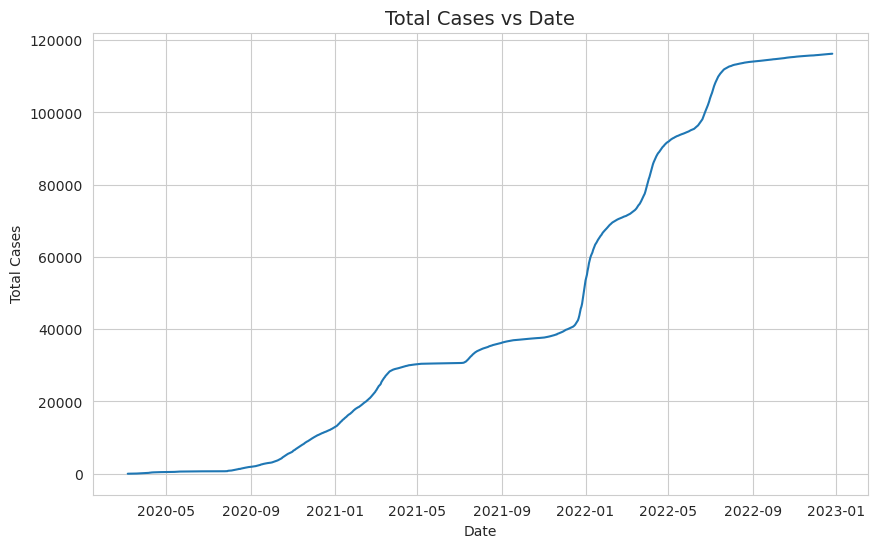

In [48]:
plot_helper('line',df_covid_agg,'date','total_cases')

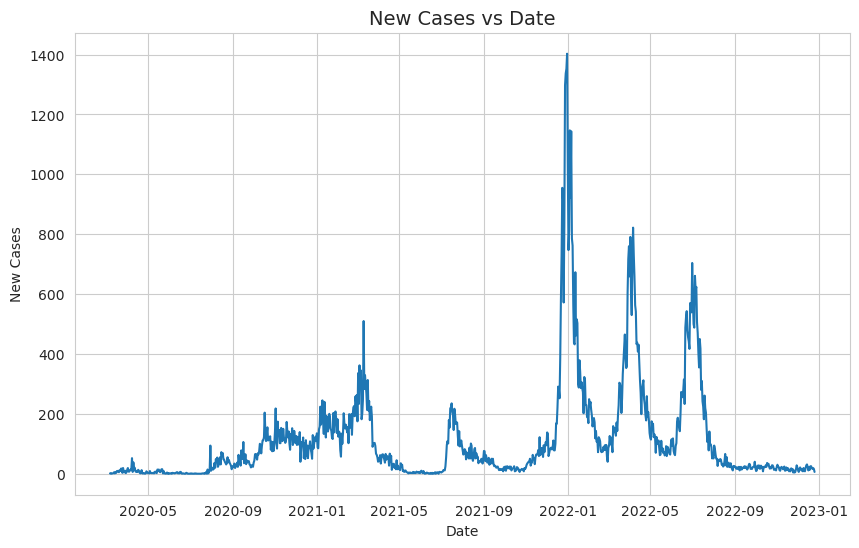

In [49]:
plot_helper('line',df_covid_agg,'date','new_cases')

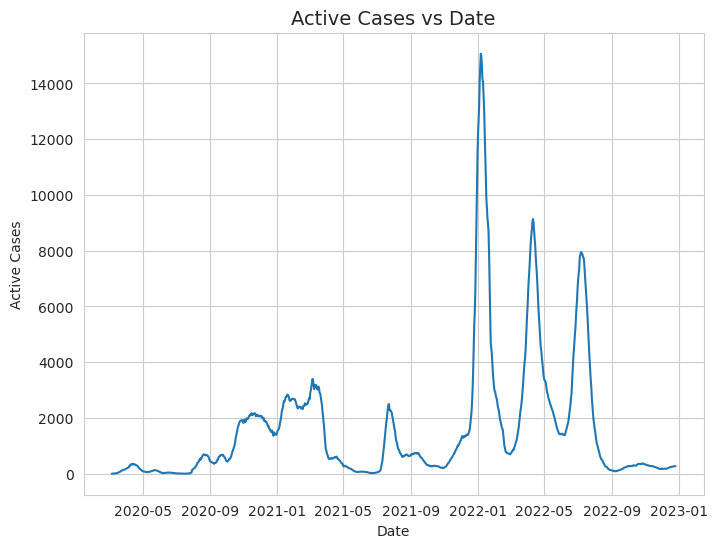

In [45]:
plot_helper('line',df_covid_agg,'date','active_cases')

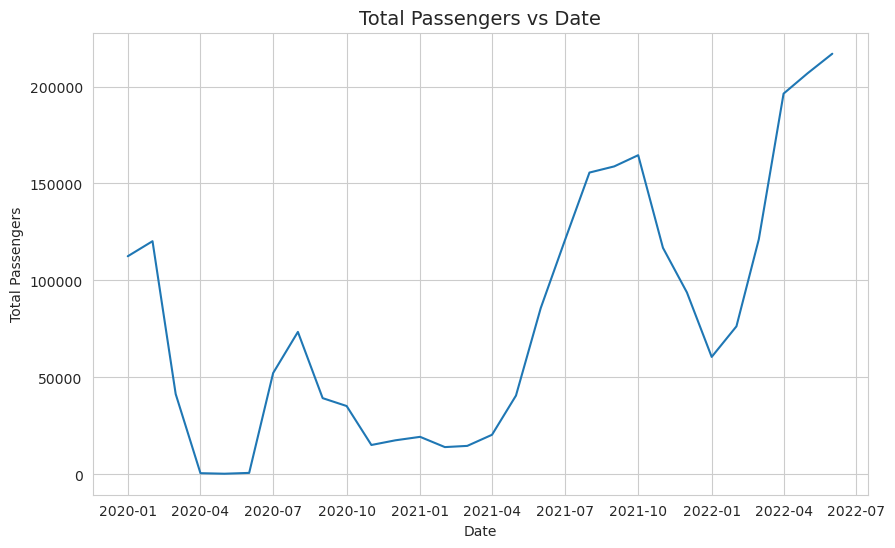

In [50]:
plot_helper('line',df_monthly_passengers,'date','total_passengers')